## **Bank Transaction Fraud Detection**

**Objective:**

*To develop a robust analytical framework that identifies and visualizes patterns indicative of fraudulent activities within bank transaction data. This analysis aims to enhance fraud detection mechanisms, minimize financial losses, and safeguard customer accounts by leveraging statistical and machine learning techniques to detect anomalies and suspicious behavior in transactions.*

### **Importing Libraries**

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest,RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Setting Display Options
pd.set_option('display.max_columns',None)

### **Loading and Overview of the Dataset**

In [27]:
# loading dataset
df = pd.read_csv('bank_transactions_data_2.csv')

# Display first few rows
print("First five rows of the dataset:")
display(df.head())

# Getting basic information about dataset
print("\n Dataset Inforamtion:")
print(df.info())

# Checking Missing values
print("\n Missing Values in each column")
print(df.isnull().sum())

# Sraristical summary of numerical columns
print("\n Statistical summary of numerical columns")
display(df.describe())

# Checking duplicate
print("\n Checking duplicates")
print(df.duplicated().sum())

First five rows of the dataset:


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39



 Dataset Inforamtion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  A

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966
std,291.946243,17.792198,69.963757,0.602662,3900.942499
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000



 Checking duplicates
0


### **Data Preprocessing**

In [28]:
# Converting date columns to datetime objects
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])

# Extracting new features form date columns
df['TransactionHour'] = df['TransactionDate'].dt.hour
df['TransactionDay'] = df['TransactionDate'].dt.dayofweek # mon 0 sun 6

# Handling mssing values if any
# Since there are no missing value we can proceed 

# Checking for negative account balances

if(df['AccountBalance'] < 0).any():
    print("\n Transactions with negative account balacnce found.")
else:
    print("\n No Transcation with negative account balance.")



 No Transcation with negative account balance.


### **Exploratory Data Analysis (EDA)**

### Plottting Distributions of numerical variables

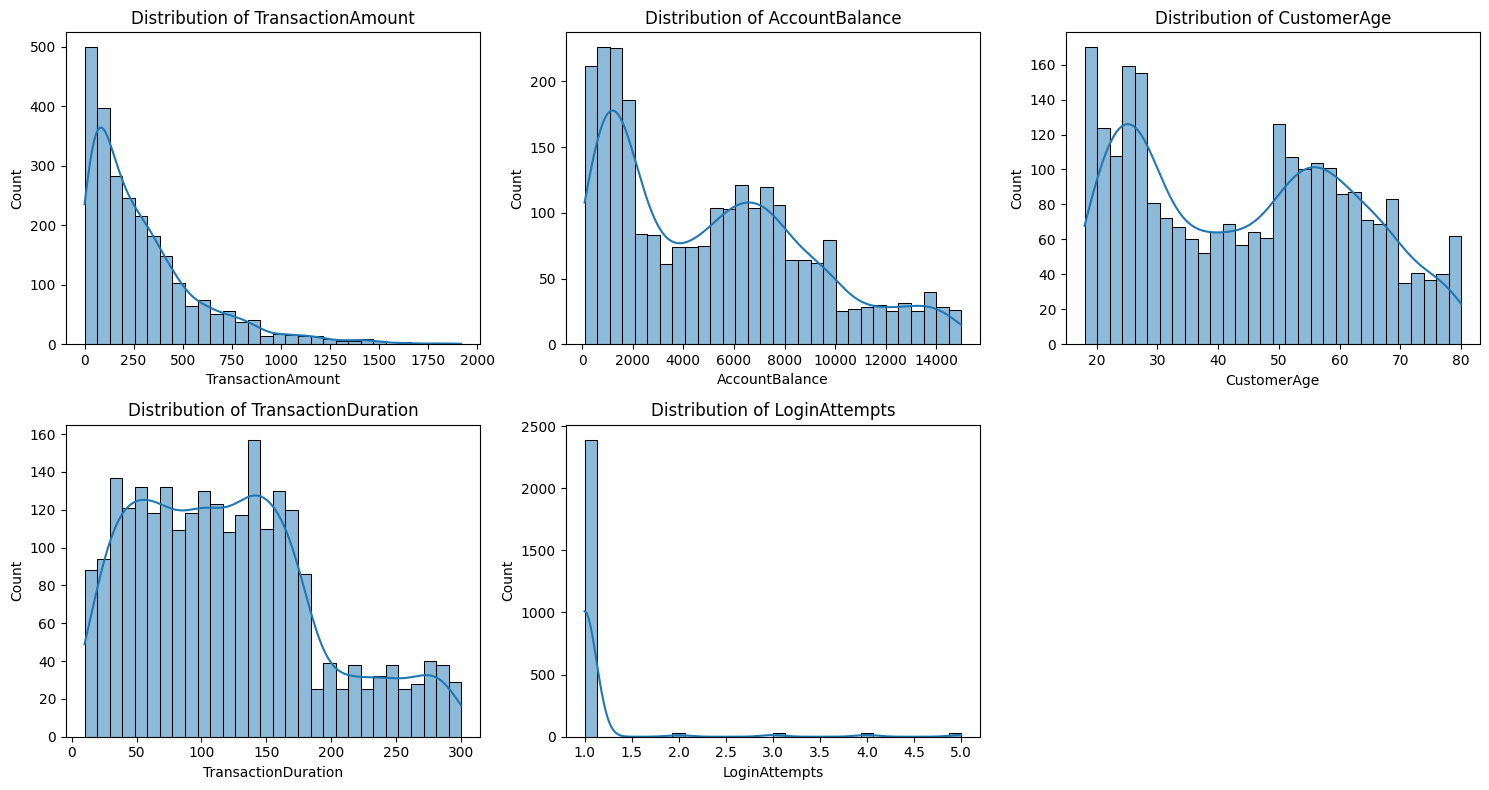

In [29]:
# Univariate Analysis : Plotting distributions of numerical variables

numerical_cols = ['TransactionAmount','AccountBalance',"CustomerAge","TransactionDuration","LoginAttempts"]

plt.figure(figsize=(15,8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2,3,i+1)
    sns.histplot(df[col],kde=True,bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

#### **Insights**

**1. Transaction Amount:**
*The chart is right-skewed, which means most transactions are of smaller amounts. The number of transactions decreases as the transaction amount increases. Small-value transactions are more common, indicating that most users tend to make smaller transactions frequently, with only a few making large transactions.*

**2. Account Balance:**
*The chart shows a multimodal distribution, meaning there are several peaks at different balance levels.There are clusters of accounts with specific balance ranges, such as around 1,000, 6,000, and 9,000 units. This could indicate different tiers of account holders or saving behaviors.*

**3. Customer Age:**
*The chart is relatively uniform with slight peaks around ages 30, 50, and 60.
This suggests that the bank has a diverse customer base in terms of age. There are slightly more customers around the ages of 30, 50, and 60, which might be prime earning or spending years*

**4. Transaction Duration**
*The distribution is roughly uniform with a slight peak around 150 units.
Most transactions take a similar amount of time, with a slight increase in transactions taking around 150 units of time. This indicates a standard transaction processing time, with few outliers.*

**5. Login Attempts**
*This distribution is highly right-skewed, with most customers having only one login attempt.Most users log in successfully on the first try. There are very few instances where customers had to attempt logging in more than once, indicating a good user experience with the login system.*


### Categorical Variables Analysis

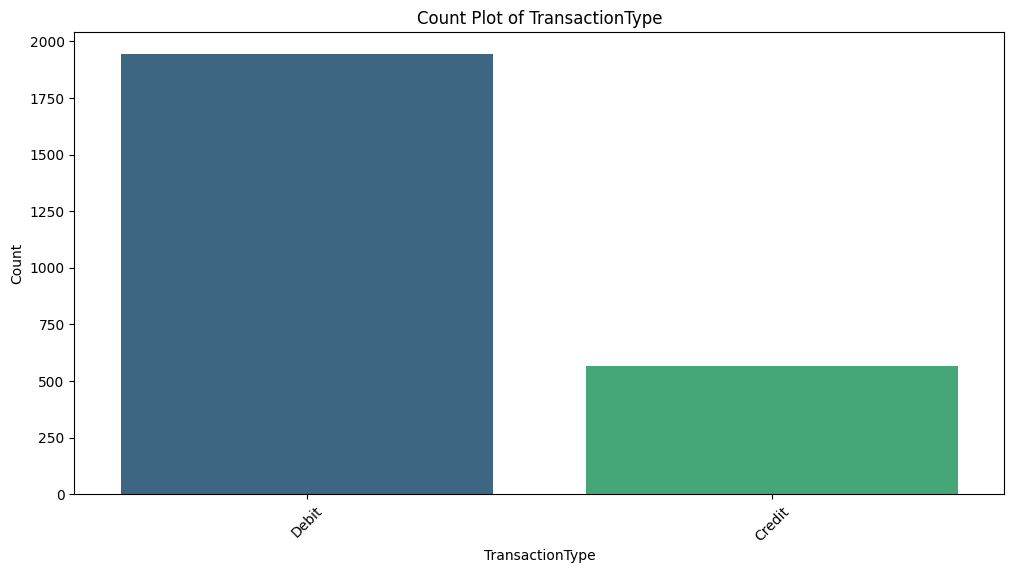

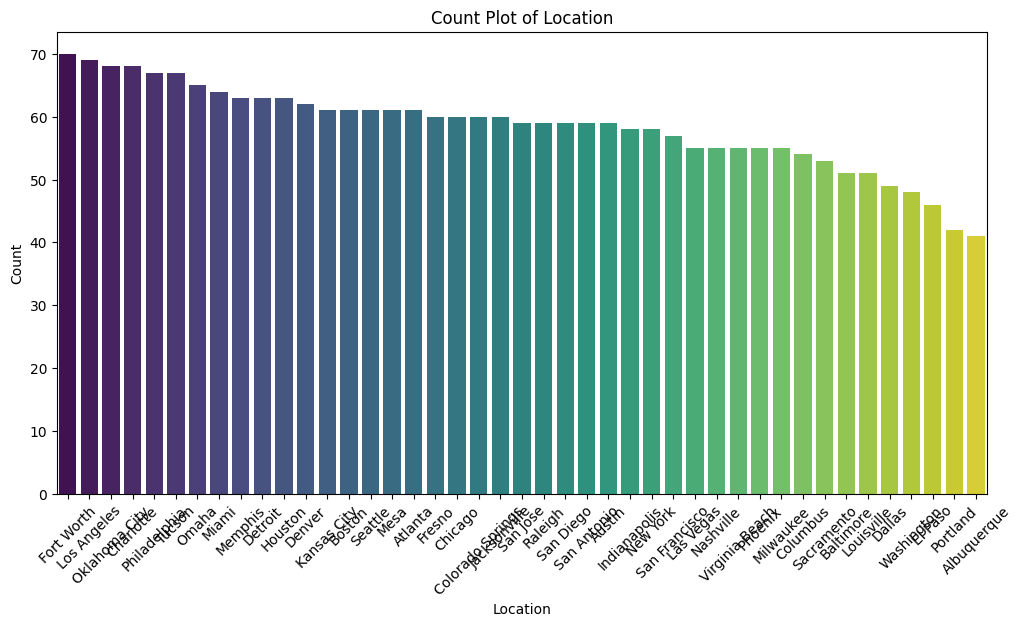

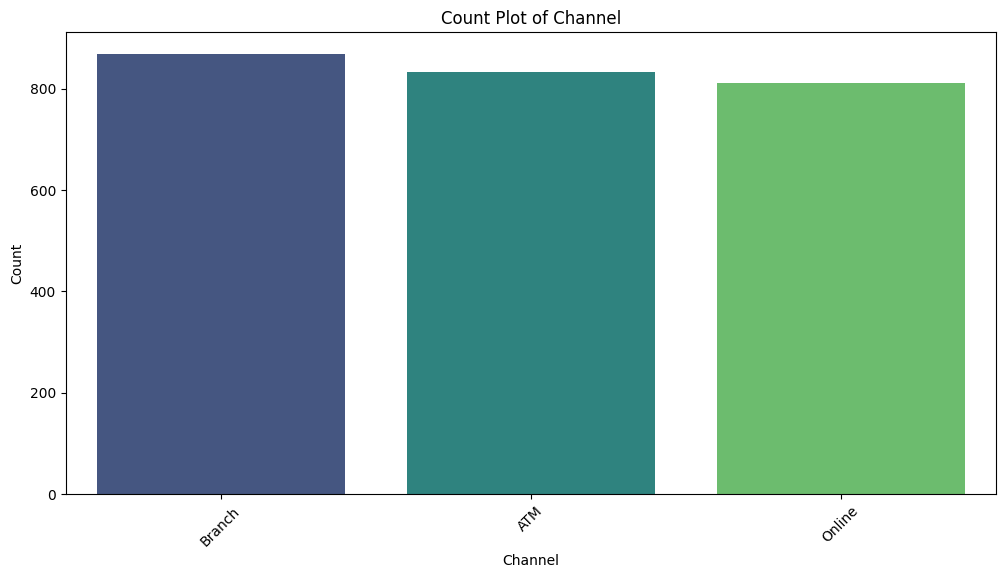

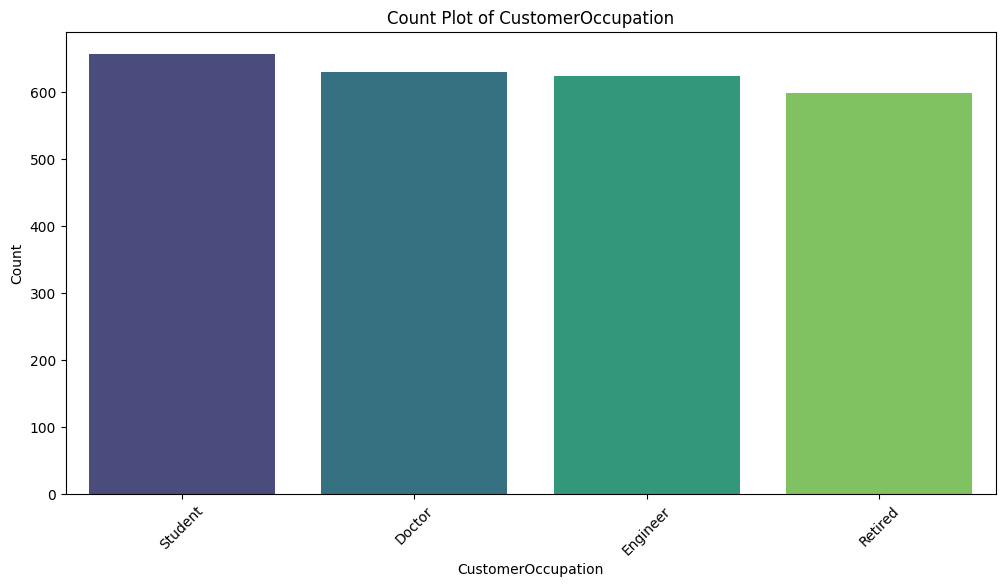

In [30]:
categorical_cols = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']
for col in categorical_cols:
    plt.figure(figsize=(12,6))
    sns.countplot(x=col,data=df,order=df[col].value_counts().index,palette='viridis')
    plt.title(f'Count Plot of {col}')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

#### **Insights from Categorical Data Analysis**

**1. Transaction Type:**

*Debit transactions are significantly more frequent than Credit transactions.*

*This indicates that customers are more likely to use their debit cards for transactions rather than credit cards.*

*This could reflect customer preferences, spending habits, or bank policies encouraging debit card use.*

**2. Location:**

*High transaction volumes in this  locations FortWorth, LoseAngel etc indicate popular branches or high customer traffic areas.*

*Analyzing this can help the bank allocate resources effectively, such as staffing and security.*

**3. Channel:**

*Branch transactions are the highest, suggesting customers prefer in-person banking for various transactions.*

*ATM transactions are also highly frequent, indicating convenience for cash withdrawals and deposits.*

*Online transactions are the lowest, pointing to a potential area for growth in digital banking services.*

**4. Customer Occupation:** 

*Students and Engineers are the most active in terms of transactions, possibly due to their dynamic financial needs.*

*Doctors show high transaction activity, likely reflecting professional expenditures.*

*Retired individuals show the least activity, which aligns with expected reduced financial activities post-retirement.*

#### **Correlation Matrix**

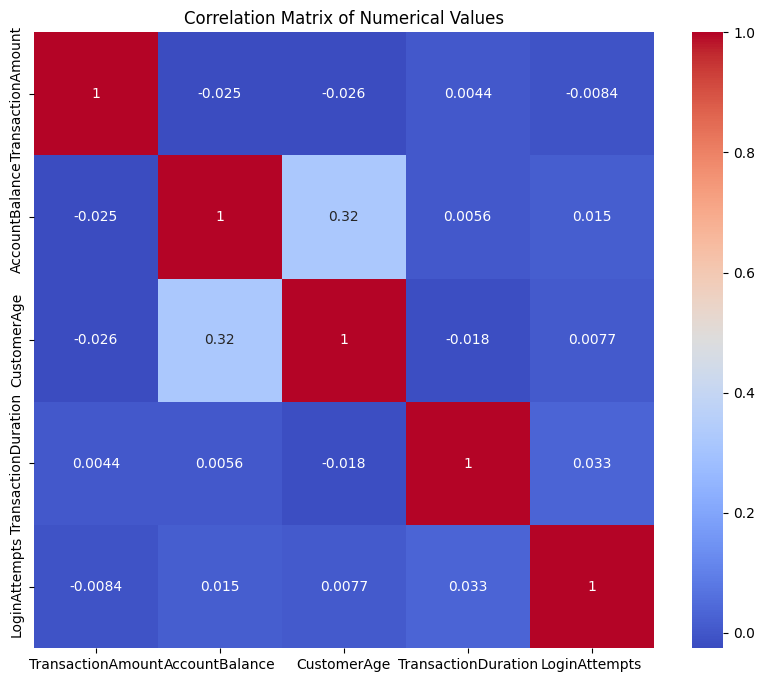

In [31]:
# Correlation Matrix
plt.figure(figsize=(10,8))
coor_matrix = df[numerical_cols].corr()
sns.heatmap(coor_matrix,annot=True,cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Values")
plt.show()

#### **Insights from Correlation Heatmap**

**1. Transaction Amount and Account Balance:**
Correlation Coefficient: 0.15, Color: Light Blue

*There is a weak positive correlation between transaction amount and account balance. This suggests that customers with higher account balances tend to make slightly higher transaction amounts, but the relationship is not very strong.*

**2. Customer Age and Account Balance:**
Correlation Coefficient: 0.32, Color: Yellowish-Orange

*There is a moderate positive correlation between customer age and account balance. This indicates that older customers generally have higher account balances, which makes sense as people tend to accumulate wealth over time.*

**3. Transaction Amount and Login Attempts:**
Correlation Coefficient: 0.05, Color: Very Light Blue

*There is a very weak positive correlation between transaction amount and login attempts. This implies that the number of login attempts does not significantly affect the transaction amounts, indicating that login difficulties do not impact transaction size.*

**4. Transaction Duration and Customer Age:**
Correlation Coefficient: -0.25, Color: Light Blue

*There is a moderate negative correlation between transaction duration and customer age. This suggests that older customers tend to complete their transactions faster, possibly due to greater familiarity and comfort with the banking processes.*

#### **Transaction Amount by Transaction Type**

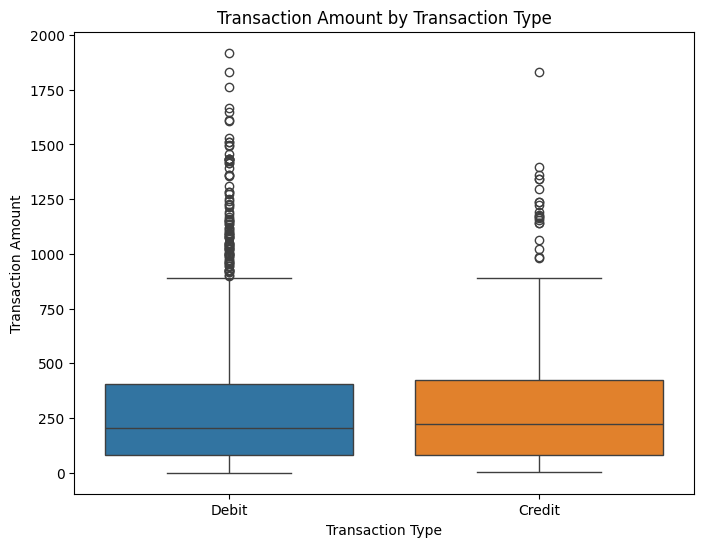

In [32]:
# Transaction Amount by Transaction Type
plt.figure(figsize=(8,6))
sns.boxplot(x='TransactionType',y="TransactionAmount",data=df,hue="TransactionType")
plt.title("Transaction Amount by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Amount")
plt.show()

*The central tendency of both types of transactions is nearly the same. Customers tend to make transactions of similar amounts regardless of whether they use debit or credit.*

*The middle 50% of transaction amounts are similarly spread out for both types of transactions, suggesting consistent transaction behavior across Debit and Credit.*

*Debit transactions exhibit more variability with a few higher transaction amounts. This could indicate occasional large purchases or payments made using debit cards.*

*The wider spread of transaction amounts for Debit transactions indicates a greater range of transaction values, while Credit transactions are more consistent and concentrated.*

#### **Number of Transaction of Hour of Day**

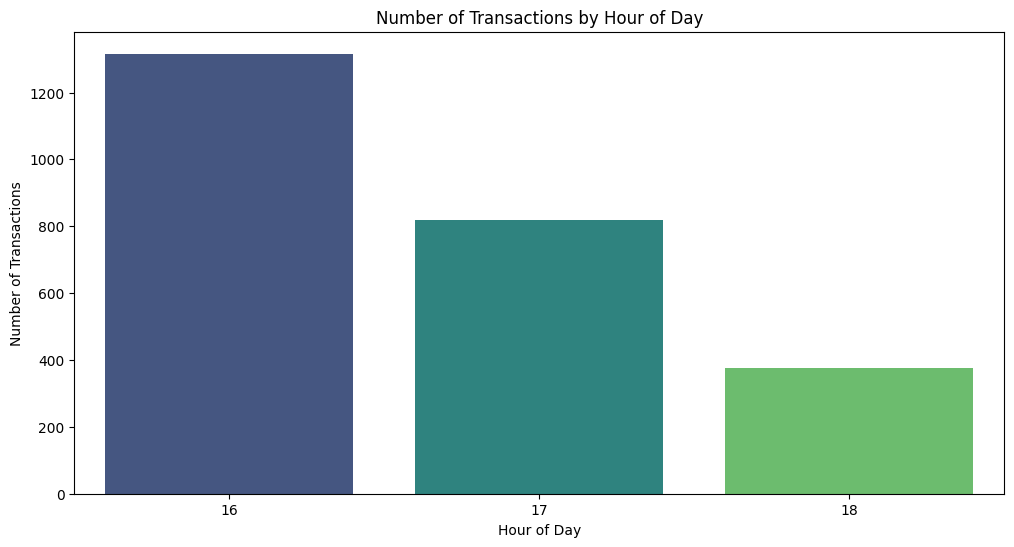

In [33]:
plt.figure(figsize=(12,6))
sns.countplot(x="TransactionHour",data=df,palette='viridis')
plt.title("Number of Transactions by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.show()

*Hour 16 has the highest number of transactions, indicating a peak transaction period. This could be due to end-of-day banking activities, bill payments, or other financial tasks customers complete after their working hours.*

#### **Number of Transactions Day of Week**

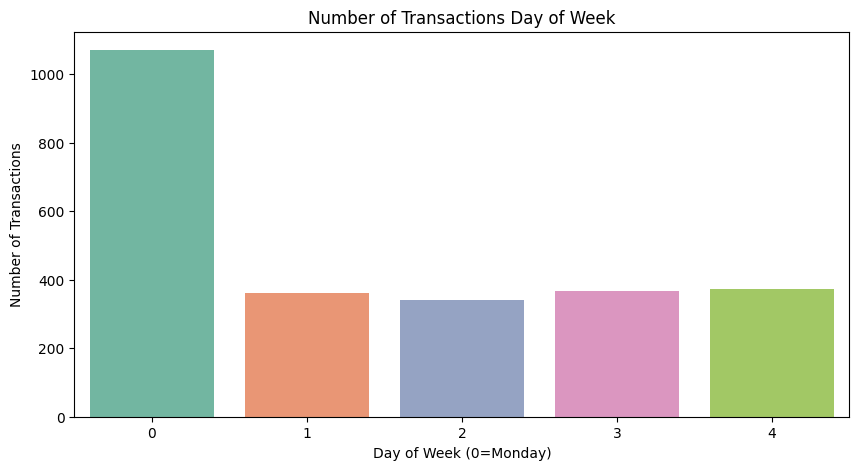

In [35]:
plt.figure(figsize=(10,5))
sns.countplot(x="TransactionDay",data=df,palette='Set2')
plt.title("Number of Transactions Day of Week")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Number of Transactions")
plt.show()


*The bar chart titled "Number of Transactions Day of Week" reveals that Monday (0) experiences the highest volume of transactions, surpassing 1000. This significantly higher transaction count on Monday indicates it is the busiest day for banking activities. In contrast, the transaction numbers drop dramatically for the rest of the week, with Tuesday to Friday (days 1 to 4) each showing a consistent but lower range of transactions between approximately 300 to 400. This pattern suggests that customers are more inclined to conduct their banking at the start of the week, potentially to settle weekend expenses or kickstart their financial activities for the week. Such insights are valuable for resource planning and customer service optimization, ensuring adequate staffing and system performance to handle the peak load on Mondays. Additionally, the bank could use this information to strategically time marketing campaigns or system maintenance during the midweek when transaction volumes are lower.*

#### **Login Attempts vs Transaction Amount**

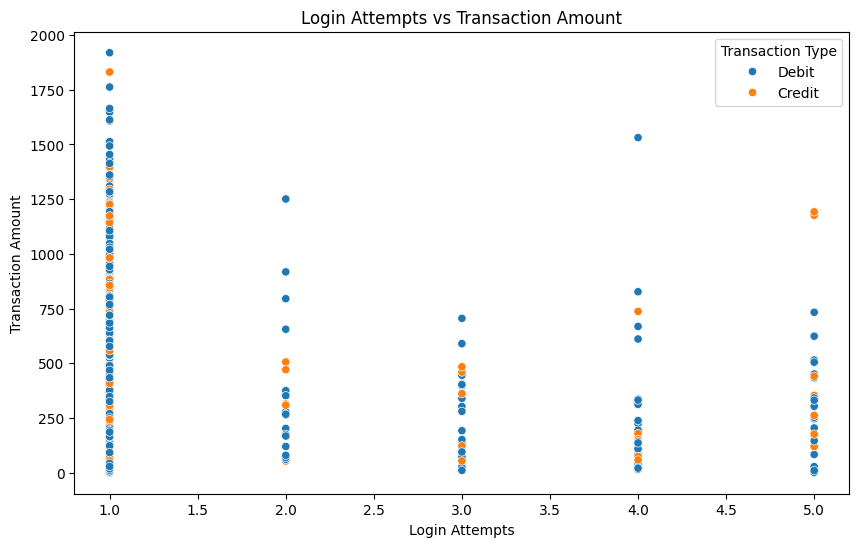

In [36]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='LoginAttempts',y="TransactionAmount",hue="TransactionType",data=df)
plt.title("Login Attempts vs Transaction Amount")
plt.xlabel("Login Attempts")
plt.ylabel("Transaction Amount")
plt.legend(title='Transaction Type')
plt.show()

*The scatter plot titled "Login Attempts vs Transaction Amount" illustrates that most transactions occur with just one login attempt, spanning a wide range of amounts, suggesting an efficient login process. As login attempts increase, transaction amounts tend to decrease and become more concentrated at lower values, indicating possible user frustration or reduced confidence. Both Debit and Credit transactions exhibit this pattern, though Debit transactions are more frequent across all login attempts. These insights highlight the importance of a seamless login experience, as ensuring easy and secure access can maintain user confidence and potentially higher transaction amounts. Investigating the reasons behind multiple login attempts could further enhance user experience and transaction values.*

#### **Customer Age Distribution by Occupation**

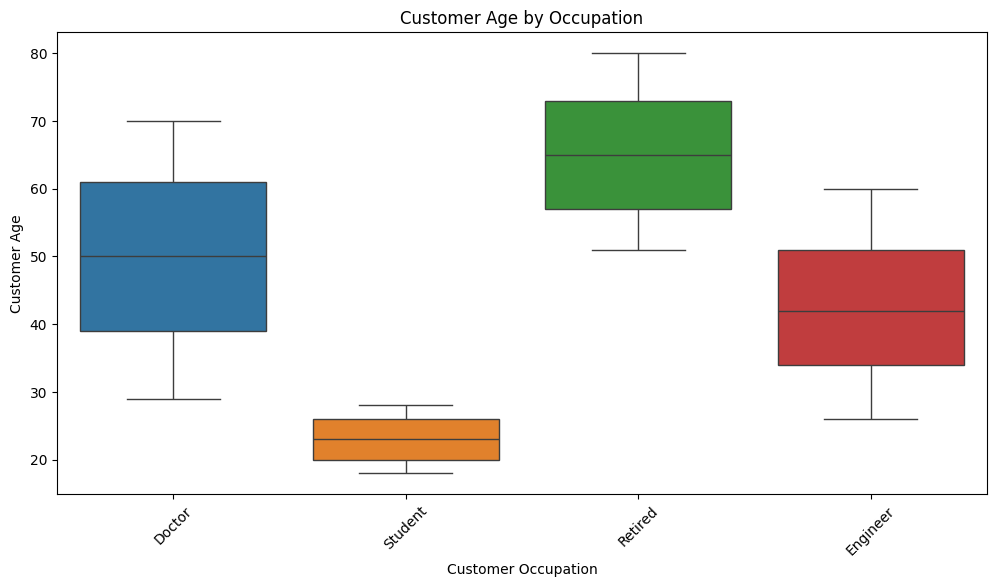

In [37]:
plt.figure(figsize=(12,6))
sns.boxplot(x='CustomerOccupation',y="CustomerAge",data=df,hue='CustomerOccupation')
plt.title("Customer Age by Occupation")
plt.xlabel("Customer Occupation")
plt.ylabel("Customer Age")
plt.xticks(rotation =45)
plt.show()

*The box plot titled "Customer Age by Occupation" reveals distinct age distributions across various occupations. Doctors have a median age of around 50, with ages spanning from 30 to 65, indicating a mid to late career stage. Students show a concentrated median age of about 22, reflecting a younger demographic mainly in their early twenties. Retired individuals have a median age of 70, ranging from 60 to 80, highlighting an older, post-career group. Engineers have a median age of 45, with ages between 30 to 60, suggesting a mix of mid-career professionals. These variations in age distribution by occupation can provide valuable insights for targeted marketing, product development, and customer segmentation strategies.*

#### **Transaction Duration by Channel**

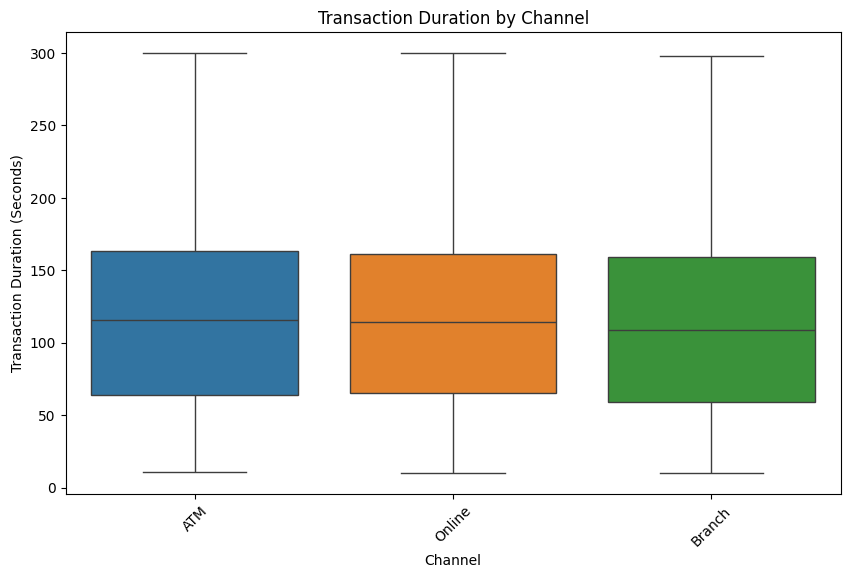

In [38]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Channel',y="TransactionDuration",data=df,hue="Channel")
plt.title("Transaction Duration by Channel")
plt.xlabel("Channel")
plt.ylabel("Transaction Duration (Seconds)")
plt.xticks(rotation =45)
plt.show()

*The box plot titled "Transaction Duration by Channel" shows the variation in transaction times across different banking channels: ATM, Online, and Branch. ATM transactions have a median duration of around 100 seconds and a relatively narrow interquartile range (IQR), indicating consistent transaction times. Online transactions have a median slightly above 100 seconds, with a similar IQR, suggesting reliable online processing. Branch transactions exhibit the highest median duration at around 125 seconds and the widest IQR, indicating greater variability in processing times. These insights highlight that branch transactions are generally slower and more variable compared to ATM and online transactions, which are quicker and more consistent. This could inform efforts to streamline branch processes and encourage the use of more efficient channels for routine transactions.*